In [70]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import GEOparse as geo
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

opengenes_df = pd.read_csv('spisok_entrez.csv', index_col=0)
opengenes_df['ncbiId'] = opengenes_df['ncbiId'].apply(str)
opengenes = opengenes_df['ncbiId'].values

def scale(df):
    tmp = df.copy()
    tmp = (tmp - tmp.mean()) / tmp.std()
    return tmp

def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    df = df.copy()
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

# GSE113957

In [72]:
df = pd.read_csv('data/GSE113957_fpkm.txt', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: 'data/GSE113957_fpkm.txt'

In [184]:
df.head(3)

,Transcript ID,chr,start,end,strand,Length,Copies,Annotation/Divergence,101_19yr_Female_Caucasian,102_19yr_Male_Caucasian,...,89_9yr_Female_Black,90_10yr_Male_Black,91_10yr_Male_Caucasian,92_11_female_Caucasian,93_11_female_Caucasian,94_12_male_Caucasian,95_13yr_Male_WhiTEEASTINDIAN,97_16yr_Female_Unknown,98_17yr_Male_Caucasian,99_17yr_Male_Caucasian
0,NM_173803,chr16,15489611,15503543,+,2233.0,1,MPV17L|M-LPH|MLPH1|MLPH2|MPV17L1|-|16p13.11|pr...,0.133,0.213,...,0.056,0.062,0.218,0.072,0.151,0.214,0.041,0.204,0.177,0.00
1,NM_014423,chr5,132211071,132299354,-,9557.0,1,AFF4|AF5Q31|CHOPS|MCEF|-|5q31.1|protein-coding,16.980,16.772,...,14.306,12.998,16.116,9.253,15.375,16.103,15.899,16.790,9.796,14.04
2,NM_001103167,chr19,10415479,10420233,-,1974.0,1,ZGLP1|GATAD3|GLP-1|GLP1|-|19p13.2|protein-coding,0.387,0.168,...,0.377,0.538,1.014,0.324,0.409,0.323,0.486,0.385,0.452,0.55


In [8]:
data = df.iloc[:, 8:]

In [33]:
meta = pd.DataFrame([c.split('_')[1:] for c in data.columns], columns=['age', 'sex', 'nationality'])
meta.age = meta.age.apply(lambda x: x.split('y')[0]).apply(lambda x: x.split('Y')[0]).apply(int)
age = meta.age.values

In [65]:
X = data.T
X = np.log2(X + 1.)
X = X.iloc[:, X.any(0).values]

In [119]:
pca = PCA(5)
Xp = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.25761393, 0.1103669 , 0.06409842, 0.04364265, 0.03564553])

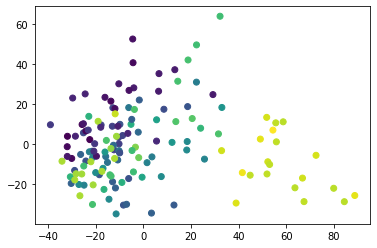

In [120]:
plt.scatter(Xp[:, 0], Xp[:, 1], c=meta.age)
#sns.scatterplot(Xp[:, 0], Xp[:, 1], hue=meta.sex)
#plt.colorbar()

In [92]:
cors = []
for i in tqdm(X.columns):
    cors.append(np.corrcoef(X[i], age)[0,1])

In [141]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X, age, random_state=9990)

In [181]:
#model = ElasticNet(alpha=5, l1_ratio=0.4)
model = SVR(kernel='linear')
#model = KNeighborsRegressor(3, metric='precomputed')

# M_train = np.corrcoef(X_train)
# M_test = np.corrcoef(X_test)

model.fit(X_train, Y_train)
y_pred_test = model.predict(X_train)
y_pred = model.predict(X_test)

In [182]:
R2 = np.corrcoef(Y_train, y_pred_test)[0, 1] ** 2
mae = np.mean(np.abs(Y_train - y_pred_test))
print(R2, mae)

0.9999911548929155 0.09950362281302606


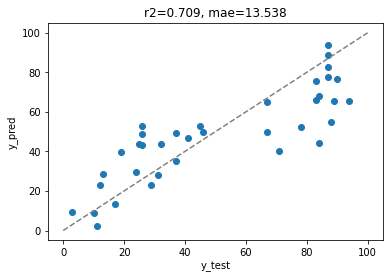

In [183]:
R2 = np.corrcoef(Y_test, y_pred)[0, 1] ** 2
mae = np.mean(np.abs(Y_test - y_pred))
plt.scatter(Y_test, y_pred)
plt.title('r2=%.3f, mae=%.3f' % (R2, mae))
plt.plot([0,100], [0, 100], color='grey', ls='--')
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

(array([ 128., 1397., 2409., 3156., 5561., 5204., 2566., 1724.,  939.,
         129.]),
 array([-6.86765692e-01, -5.49427818e-01, -4.12089945e-01, -2.74752072e-01,
        -1.37414199e-01, -7.63256627e-05,  1.37261548e-01,  2.74599421e-01,
         4.11937294e-01,  5.49275167e-01,  6.86613040e-01]),
 <a list of 10 Patch objects>)

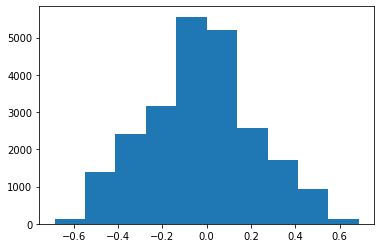

In [94]:
plt.hist(cors)

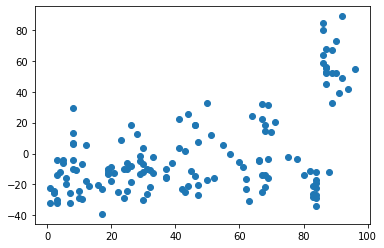

In [195]:
plt.scatter(age, Xp[:,0])

# GSE65907

In [4]:
#df_full = pd.read_csv('data/GSE65907/GSE65907_non_normalized_28277probes.txt', sep='\t', index_col=0)
#df = df_full.iloc[:, 0::2]

In [3]:
df = pd.read_csv('data/GSE65907/GSE65907_data.csv', sep='\t', index_col=0)
meta = pd.read_csv('data/GSE65907/GSE65907_metadata.csv', index_col=0)

In [4]:
annot = pd.read_csv('data/GSE65907/GPL10558-50081.txt', sep='\t', skiprows=30, index_col=0)
annot = annot.loc[df.index]
key_annot = annot[['ILMN_Gene', 'Entrez_Gene_ID', 'Symbol', 'Synonyms', 
                   'Definition', 'Ontology_Process', 'Ontology_Function']]

In [5]:
age = meta['characteristics_ch1.1.age (yrs)'].values
sex = meta['characteristics_ch1.0.gender'].values

In [6]:
todrop = key_annot['Entrez_Gene_ID'][key_annot['Entrez_Gene_ID'].isna()]

In [7]:
df_filt = df.drop(todrop.index)

In [8]:
etz = key_annot['Entrez_Gene_ID'].drop(todrop.index).apply(int).apply(str)
etz.name = 'Entrez'

In [9]:
df_grouped = df_filt.groupby(etz).sum()

In [10]:
df_log = np.log2(df_grouped + 1)

In [11]:
df_scaled = quantile_normalize(scale(df_log))

In [12]:
X = df_scaled.T

In [13]:
X_open_genes = X[X.columns.intersection(opengenes)]
m = len(X.columns.intersection(opengenes))

In [14]:
X_random_genes = X[np.random.choice(X.columns, size=m, replace=False)]

In [15]:
pca = PCA(2)
Xp = pca.fit_transform(X)

pca_og = PCA(2)
Xp_og = pca_og.fit_transform(X_open_genes)

pca_r = PCA(2)
Xp_r = pca_r.fit_transform(X_random_genes)

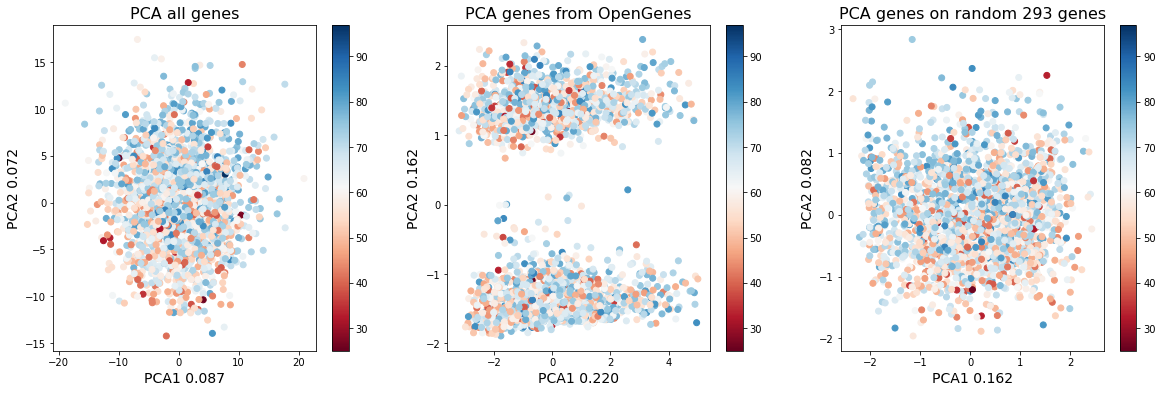

In [16]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title('PCA all genes', fontsize=16)
plt.scatter(Xp[:, 0], Xp[:, 1], c=age, cmap='RdBu')
#sns.scatterplot(Xp[:, 0], Xp[:, 1], hue=sex)
plt.xlabel('PCA1 %.3f' % pca.explained_variance_ratio_[0], fontsize=14)
plt.ylabel('PCA2 %.3f' % pca.explained_variance_ratio_[1], fontsize=14)
plt.colorbar()

plt.subplot(132)
plt.title('PCA genes from OpenGenes', fontsize=16)
plt.scatter(Xp_og[:, 0], Xp_og[:, 1], c=age, cmap='RdBu')
plt.xlabel('PCA1 %.3f' % pca_og.explained_variance_ratio_[0], fontsize=14)
plt.ylabel('PCA2 %.3f' % pca_og.explained_variance_ratio_[1], fontsize=14)
plt.colorbar()

plt.subplot(133)
plt.title('PCA genes on random %d genes' % m, fontsize=16)
plt.scatter(Xp_r[:, 0], Xp_r[:, 1], c=age, cmap='RdBu')
plt.xlabel('PCA1 %.3f' % pca_r.explained_variance_ratio_[0], fontsize=14)
plt.ylabel('PCA2 %.3f' % pca_r.explained_variance_ratio_[1], fontsize=14)
plt.colorbar()

plt.show()

In [76]:
corrs = []
for i in X_open_genes.columns:
    corrs.append(np.corrcoef(X_open_genes[i], Xp_og[:, 1])[0, 1])

plt.hist(corrs)

In [80]:
np.argwhere(np.array(corrs) > 0.5)

array([[114]])

<AxesSubplot:title={'center':'3123'}, ylabel='Density'>

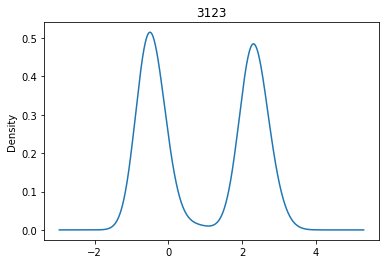

In [90]:
X_open_genes.iloc[:, 114].plot(kind='kde', title=X_open_genes.iloc[:, 114].name)

/gss/home/d.kriukov/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'expression')

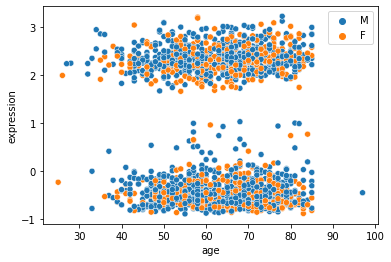

In [110]:
sns.scatterplot(age, X_open_genes.iloc[:, 114], hue=sex)
plt.xlabel('age')
plt.ylabel('expression')

<AxesSubplot:>

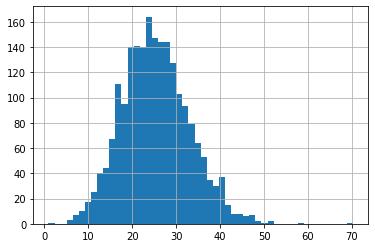

In [111]:
meta['characteristics_ch1.2.lymphocytes'].hist(bins=50)

<AxesSubplot:>

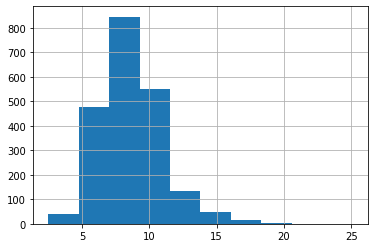

In [97]:
meta['characteristics_ch1.3.monocytes'].hist()

In [108]:
meta['characteristics_ch1.6.processing_batch']

GSM1608849    p20
GSM1608850    p42
GSM1608851     p3
GSM1608852    p12
GSM1608853    p26
             ... 
GSM1611030     p2
GSM1611031     p3
GSM1611032     p8
GSM1611033    p17
GSM1611034    p53
Name: characteristics_ch1.6.processing_batch, Length: 2112, dtype: object

In [102]:
meta.columns

Index(['title', 'geo_accession', 'status', 'submission_date',
       'last_update_date', 'type', 'channel_count', 'source_name_ch1',
       'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.gender',
       'characteristics_ch1.1.age (yrs)', 'characteristics_ch1.2.lymphocytes',
       'characteristics_ch1.3.monocytes', 'characteristics_ch1.4.cell type',
       'characteristics_ch1.5.sentrix_id',
       'characteristics_ch1.6.processing_batch', 'molecule_ch1',
       'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1',
       'hyb_protocol', 'scan_protocol', 'description', 'data_processing',
       'platform_id', 'contact_name', 'contact_email', 'contact_phone',
       'contact_laboratory', 'contact_department', 'contact_institute',
       'contact_address', 'contact_city', 'contact_state',
       'contact_zip/postal_code', 'contact_country', 'supplementary_file',
       'series_id', 'data_row_count'],
      dtype='object')

In [46]:
corrs = []
for col in X.columns:
    c = np.corrcoef(X[col], age)[0, 1]
    corrs.append(c)

In [41]:
np.argmax(corrs)

90

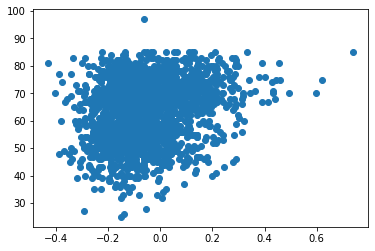

In [42]:
plt.scatter(X.iloc[:, 90], age)

(array([ 1.,  5.,  5.,  9., 27., 63., 92., 52., 25., 14.]),
 array([-0.35178028, -0.29546553, -0.23915077, -0.18283601, -0.12652126,
        -0.0702065 , -0.01389174,  0.04242301,  0.09873777,  0.15505253,
         0.21136728]),
 <BarContainer object of 10 artists>)

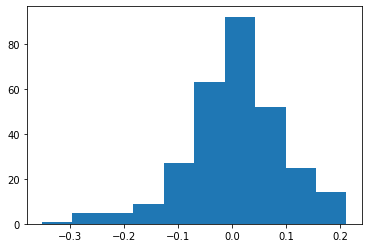

In [43]:
plt.hist(corrs)

# E-MTAB-1788

# model

In [17]:
from sklearn.linear_model import (ElasticNet, LinearRegression, Ridge, SGDRegressor, 
                                    ARDRegression, BayesianRidge, HuberRegressor)
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
#from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn import metrics

## feature selection

In [18]:
corrs = []
for col in X.columns:
    c = np.corrcoef(X[col], age)[0, 1]
    corrs.append(c)

In [19]:
# select top correlated features
top = 2000
M = 1 - top / len(corrs)
ids = np.argwhere(np.abs(corrs) > np.quantile(np.abs(corrs), M)).ravel()

X_corr = X.iloc[:, ids]

## run model

In [20]:
X_ = X_corr

In [21]:
am = 0 #age.mean()
asd = 1 #age.std()
age_norm = age #(age - am) / asd

scalerX = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X_, age_norm, test_size=0.15, stratify=sex)

X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

In [23]:
scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better=False)
def benchmark(model, parameters, X, y):
    grid = GridSearchCV(model, parameters, scoring=scorer, cv=5)
    grid.fit(X, y)
    best_score = grid.best_score_
    best_params = grid.best_params_
    return type(model).__name__, best_score, best_params, grid.best_estimator_

models = [
    (ElasticNet(max_iter=10000), {'alpha':np.logspace(-2, 2, 10), 'l1_ratio' :np.arange(0.1,0.2,0.9)}),
    # (LinearSVR(), {'C':np.arange(0.1, 10, 0.8), 'epsilon':np.arange(0, 5, 0.5)}),
    # (ARDRegression(n_iter=5000), {}),
    # (BayesianRidge(n_iter=5000), {'alpha_1':[1e-7, 1e-6, 1e-5], 'alpha_2':[1e-7, 1e-6, 1e-5]}),
    # (KNeighborsRegressor(), {'n_neighbors':np.arange(2,12,1), 'weights':['uniform', 'distance'], 'p':[1,2,50]}),
    # (RandomForestRegressor(n_estimators=300), {'max_depth':[3,4,5,6,7,8]}),
]

In [24]:
print('MAE dummy', np.mean(np.abs(asd * (y_test - y_train.mean()))))
print()
for reg, params in models:
    name, score, params, best = benchmark(reg, params, X_train, y_train)
    y_pred_test = best.predict(X_test)
    y_pred_train = best.predict(X_train)
    print(name, score, params)
    print('MAE train:', np.mean(np.abs(y_train - y_pred_train)))
    print('MAE test:', np.mean(np.abs(y_test - y_pred_test)))
    print('R2 train score:', r2_score(y_train, y_pred_train))
    print('R2 test score:', r2_score(y_test, y_pred_test))
    print()

MAE dummy 9.39051343110463

ElasticNet -5.649841901558203 {'alpha': 0.21544346900318834, 'l1_ratio': 0.1}
MAE train: 3.470453900113692
MAE test: 5.36644037804738
R2 train score: 0.8413239108376244
R2 test score: 0.622295322908799



In [27]:
wei = best.coef_

In [43]:
og_intsec = X_.columns.intersection(opengenes).values
og_ids = [X_.columns.get_loc(c) for c in og_intsec]

In [73]:
ogdf = pd.DataFrame({'etz': og_intsec, 'w': wei[og_ids]}).sort_values('w', ascending=False)
ogdf = ogdf.merge(opengenes_df, left_on='etz', right_on='ncbiId')

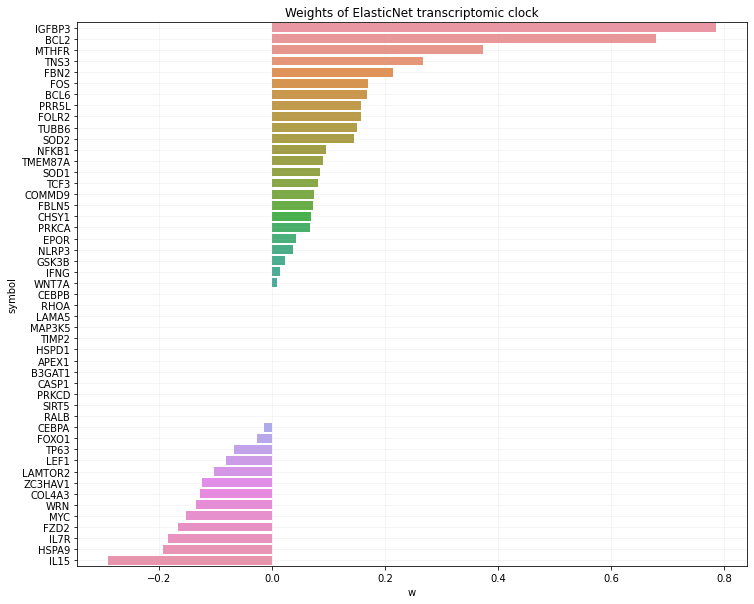

In [77]:
plt.figure(figsize=(12,10))
sns.barplot(data=ogdf, x='w', y='symbol', orient='h')
plt.title('Weights of ElasticNet transcriptomic clock')
plt.grid(alpha=0.15)
plt.show()

In [22]:
# regr = ElasticNet(alpha=0.1, l1_ratio=.9)
#regr = SVR(kernel='linear') 
#regr = LGBMRegressor(boosting_type='dart')
#regr = MLPRegressor(hidden_layer_sizes=(700, 50, 50, 50, 50),  learning_rate_init=0.0001, solver='adam')

# regr.fit(X_train, y_train)

# y_pred_train = regr.predict(X_train) * asd + am
# y_pred = regr.predict(X_test) * asd + am

# print('MAE dummy', np.mean(np.abs(asd * (y_test - y_train.mean()))))
# print('MAE train:', np.mean(np.abs(y_pred_train - y_train*asd + am)))
# print('MAE test:', np.mean(np.abs(y_pred - y_test*asd + am)))

# print('R:', np.corrcoef(y_pred, y_test)[0,1])


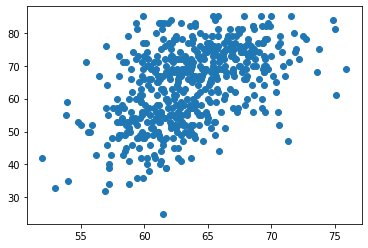

In [57]:
plt.scatter(y_pred, y_test)